# Analysis of Avocado Sales

## Background

Here I analyze [Mass avocado sales data](https://www.kaggle.com/neuromusic/avocado-prices) provided by the Hass Avocado Board.

The analysis covers **retrieving data from a database, data manipulation, computation and visualization,** as well as **answering business questions.**

The analysis is primarily based in Python with a little SQL.

It uses $Numpy$ and $Pandas$ for data manipulation, $Sqlite3$ for accessing the database, and seaborn for visualization.

In [1]:
%%capture
import numpy as np
import pandas as pd
import sqlite3

# Plotting libraries and settings
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 6)
plt.style.use('seaborn-darkgrid')
import seaborn as sns
# plt.style.use('fivethirtyeight')

## Exploring the database & retrieving the data

The data is stored in a sqlite database `avocado.sqlite`. Let's explore the database to see what tables are available.

In [2]:
conn = sqlite3.connect('avocado.db')
pd.read_sql("SELECT name FROM sqlite_master", conn)

,name
0,avocado_sales


In [3]:
pd.read_sql('PRAGMA table_info(avocado_sales)', conn)

,cid,name,type,notnull,dflt_value,pk
0,0,idx,INTEGER,0,None,0
1,1,date,TEXT,0,None,0
2,2,average_price,REAL,0,None,0
3,3,total_volume,REAL,0,None,0
4,4,field5,REAL,0,None,0
5,5,field6,REAL,0,None,0
6,6,field7,REAL,0,None,0
7,7,total_bags,REAL,0,None,0
8,8,small_bags,REAL,0,None,0
9,9,large_bags,REAL,0,None,0


In [4]:
pd.read_sql('SELECT * FROM avocado_sales LIMIT 2', conn)

,idx,date,average_price,total_volume,field5,field6,field7,total_bags,small_bags,large_bags,xlarge_bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany


The columns needed for analysis are $date$, $year$, $type$, $average$ $price$, $region$, $size$ and $number$ $of$ $bags$ $sold$.

In [5]:
query = """
SELECT
    date, 
    year,
    type,
    average_price,
    region,
    CASE 
        WHEN (total_volume >= 84.56) AND (total_volume < 10838.58) THEN 'small'
        WHEN (total_volume >= 10838.58) AND (total_volume < 107376.76) THEN 'medium'
        WHEN (total_volume >= 107376.76) AND (total_volume < 432962.29) THEN 'large'
        ELSE 'extra large'
    END size,
    total_bags AS nb_sold
FROM avocado_sales;
"""
avocado_sales = pd.read_sql(query, conn)
display(avocado_sales.head())

,date,year,type,average_price,region,size,nb_sold
0,2015-12-27,2015,conventional,1.33,Albany,medium,8696.87
1,2015-12-20,2015,conventional,1.35,Albany,medium,9505.56
2,2015-12-13,2015,conventional,0.93,Albany,large,8145.35
3,2015-12-06,2015,conventional,1.08,Albany,medium,5811.16
4,2015-11-29,2015,conventional,1.28,Albany,medium,6183.95


In [6]:
length = len(avocado_sales)
pct_25 = length * 0.25
pct_50 = length * 0.50
pct_75 = length * 0.75
pct_100 = length * 1.00

pct_25,pct_50,pct_75,pct_100

(4562.25, 9124.5, 13686.75, 18249.0)

## Which types and sizes of avocado have the highest sales volumes?

In [7]:
avocado_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           18249 non-null  object 
 1   year           18249 non-null  object 
 2   type           18249 non-null  object 
 3   average_price  18249 non-null  float64
 4   region         18249 non-null  object 
 5   size           18249 non-null  object 
 6   nb_sold        18249 non-null  float64
dtypes: float64(2), object(5)
memory usage: 641.6+ KB


In [8]:
avocado_sales['date'] = pd.to_datetime(avocado_sales['date'])
avocado_sales['year'] = avocado_sales['date'].dt.year

In [9]:
avocado_sales = (
    avocado_sales
        .assign(type_size = lambda x : x['type'] + ', ' +  x['size'])
        
)
avocado_sales['type_size'].unique().tolist()

['conventional, medium',
 'conventional, large',
 'conventional, extra large',
 'organic, small',
 'organic, medium',
 'organic, large',
 'organic, extra large']

By far the highest volume of sales came from organic and conventional extra large  avocados. For both types of avocado, small sizes had lower sales volumes.

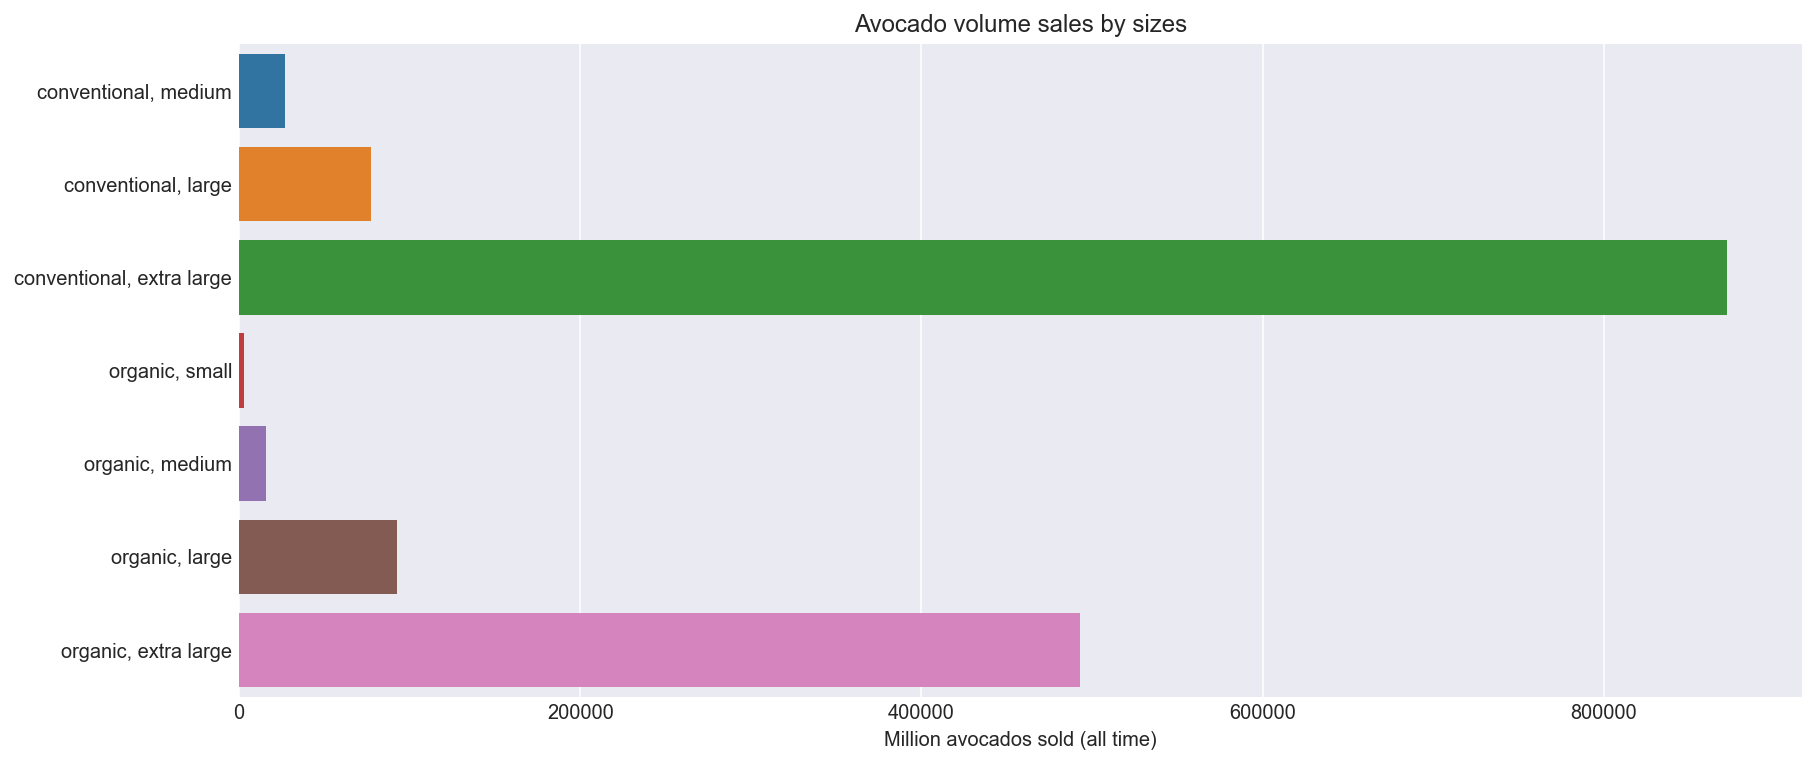

In [10]:
ax = sns.barplot(
    data = avocado_sales,
    x = 'nb_sold',
    y = 'type_size',
    ci = None
)
ax.set (
    xlabel = 'Million avocados sold (all time)',
    ylabel = None,
    title = 'Avocado volume sales by sizes'
)
plt.show()

## How do sales vary over time for each type and size of avocado?

When looking at the sales volumes throughout the 2015 to 2018 period, a couple of noteable trends are:
   -   For $conventional$ avocados, sales of the $extra$ $large$ size fropped off after mid 2018 (though volumes were low to begin with).
   -  For $organic$ avocados, sales of the small size dropped off in 2015 to make large avocados the $dominant$ $size$.
   -  There is some $seasonality$ that deserves a closer look.

In [11]:
avocado_sales_2018 = (
    avocado_sales
        .query('year == 2018')
)
avocado_sales_2018.head()

,date,year,type,average_price,region,size,nb_sold,type_size
8478,2018-03-25,2018,conventional,1.57,Albany,large,23924.33,"conventional, large"
8479,2018-03-18,2018,conventional,1.35,Albany,medium,30977.21,"conventional, medium"
8480,2018-03-11,2018,conventional,1.12,Albany,large,17804.72,"conventional, large"
8481,2018-03-04,2018,conventional,1.08,Albany,large,22353.29,"conventional, large"
8482,2018-02-25,2018,conventional,1.28,Albany,medium,34138.80,"conventional, medium"


In [12]:
type_sizes = avocado_sales['type_size'].unique().tolist()
type_sizes

['conventional, medium',
 'conventional, large',
 'conventional, extra large',
 'organic, small',
 'organic, medium',
 'organic, large',
 'organic, extra large']

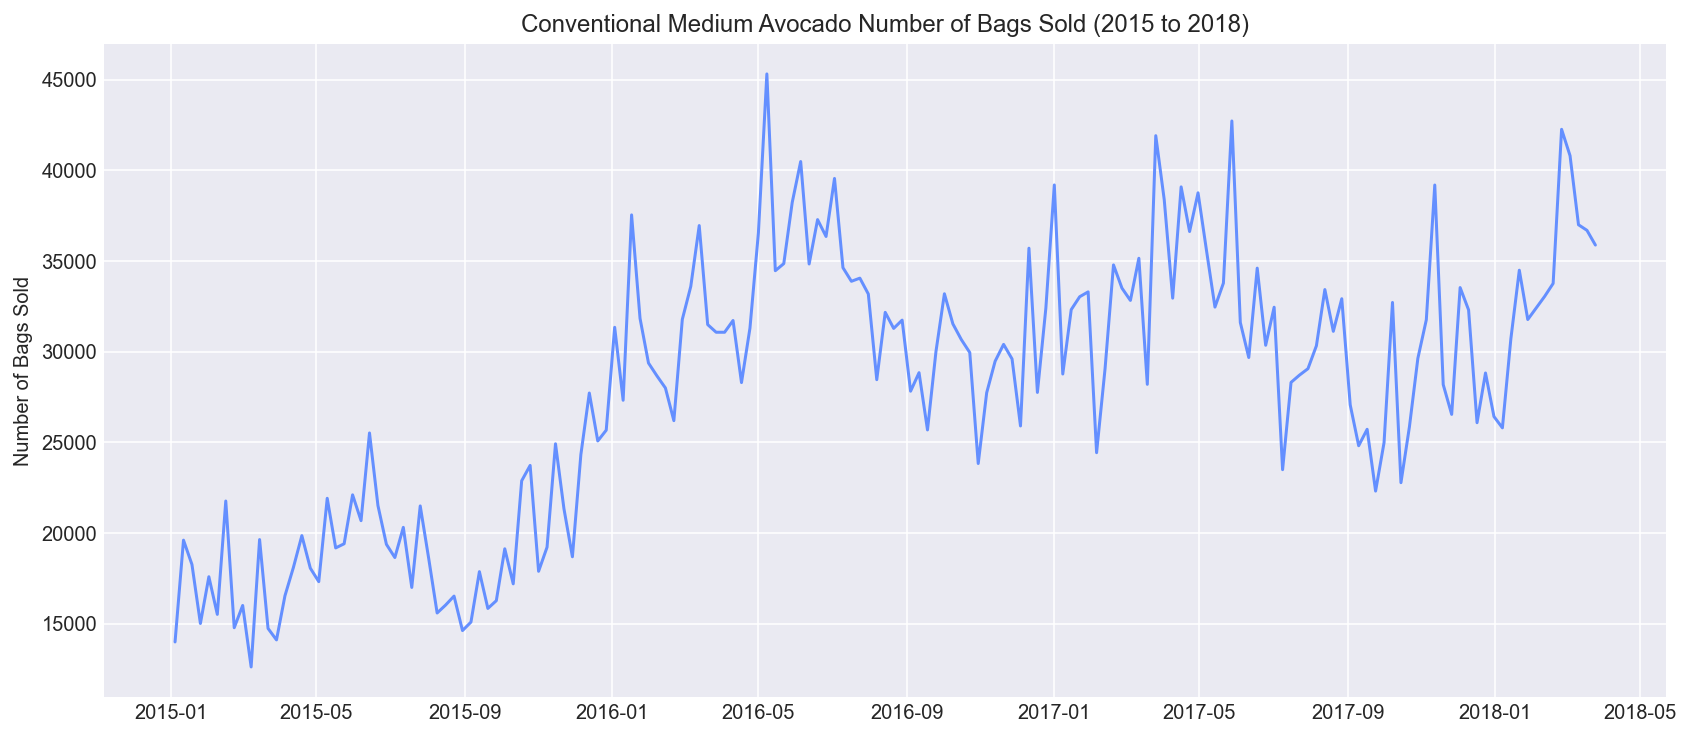

In [42]:
data = (
        avocado_sales
            .query('type_size == "conventional, medium"'))
ax = (
        sns
            .lineplot(
            data = data ,
            x = 'date',
            y = 'nb_sold', 
            color='#648FFF',
            ci = None)

)
ax.set (
    ylabel = 'Number of Bags Sold',
    xlabel = None,
    title = 'Conventional Medium Avocado Number of Bags Sold (2015 to 2018)'
)
plt.show()

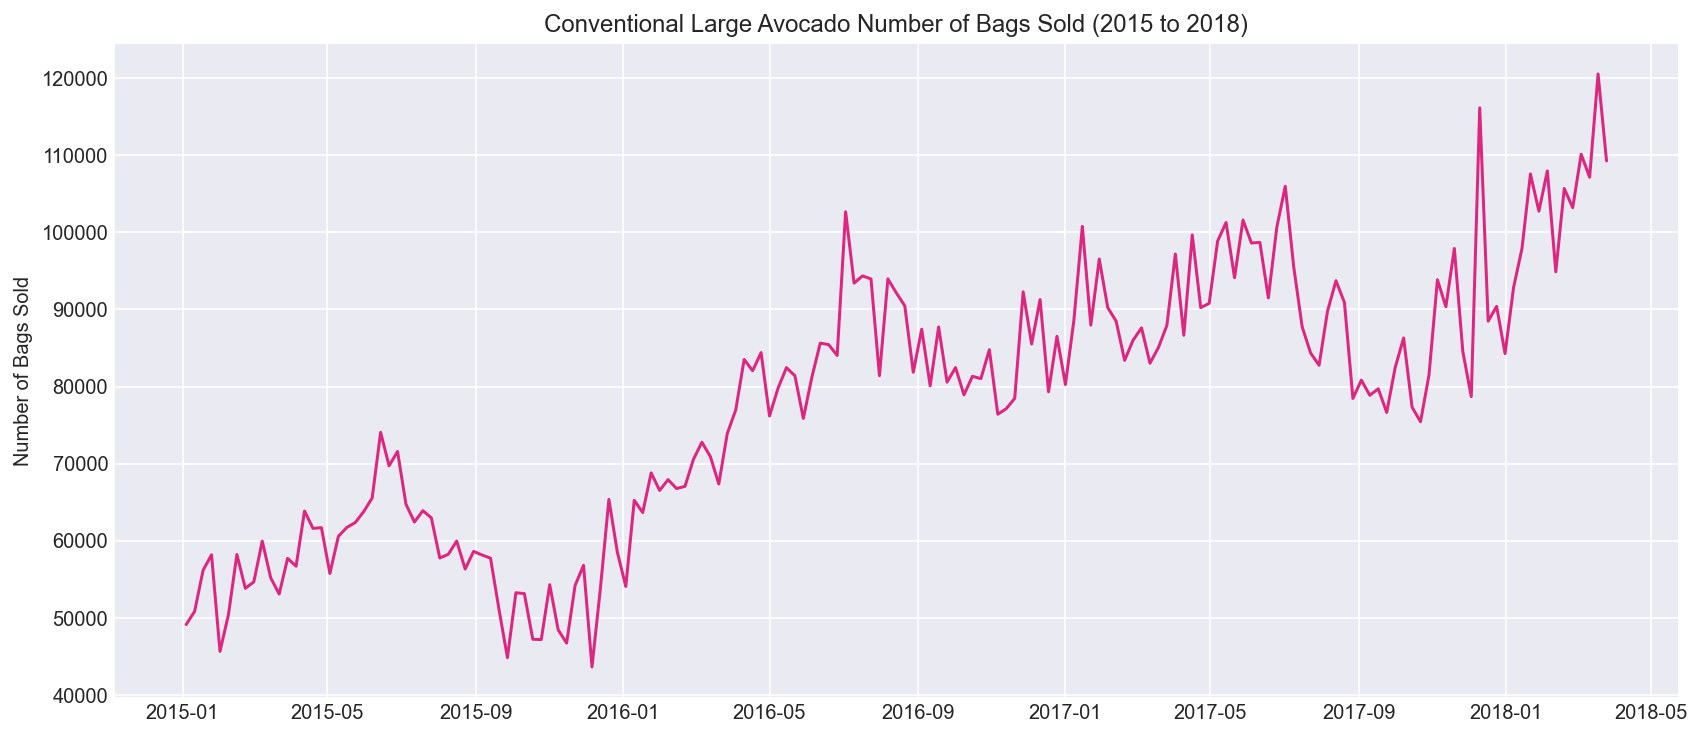

In [43]:
data = (
        avocado_sales
            .query('type_size == "conventional, large"'))
ax = (
        sns
            .lineplot(
            data = data ,
            x = 'date',
            y = 'nb_sold', 
            color='#DC267F',
            ci = None)

)
ax.set (
    ylabel = 'Number of Bags Sold',
    xlabel = None,
    title = 'Conventional Large Avocado Number of Bags Sold (2015 to 2018)'
)
plt.show()

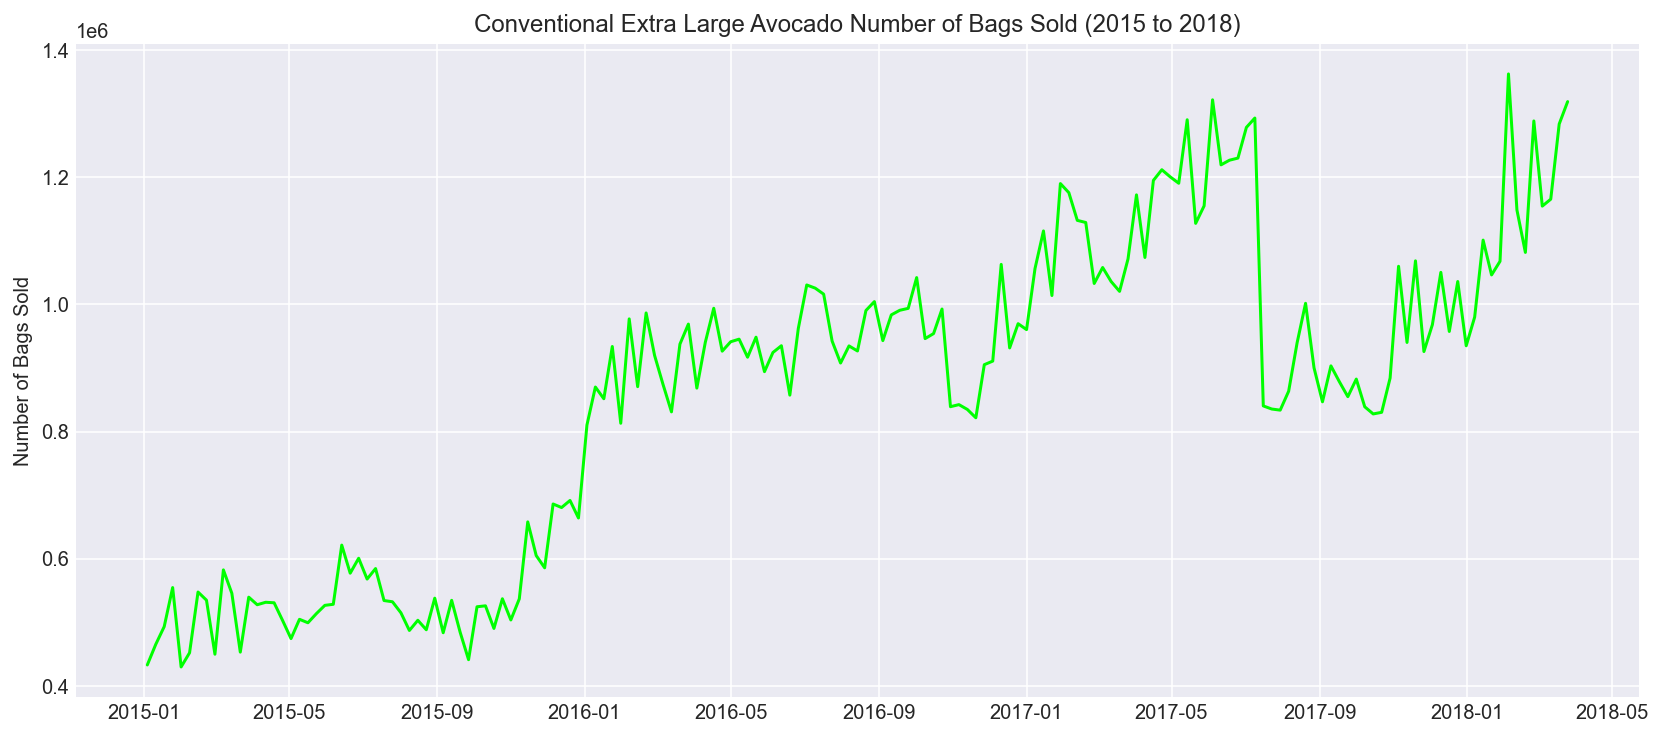

In [44]:
data = (
        avocado_sales
            .query('type_size == "conventional, extra large"'))
ax = (
        sns
            .lineplot(
            data = data ,
            x = 'date',
            y = 'nb_sold', 
            color='#00FF00',
            ci = None)

)
ax.set (
    ylabel = 'Number of Bags Sold',
    xlabel = None,
    title = 'Conventional Extra Large Avocado Number of Bags Sold (2015 to 2018)'
)
plt.show()

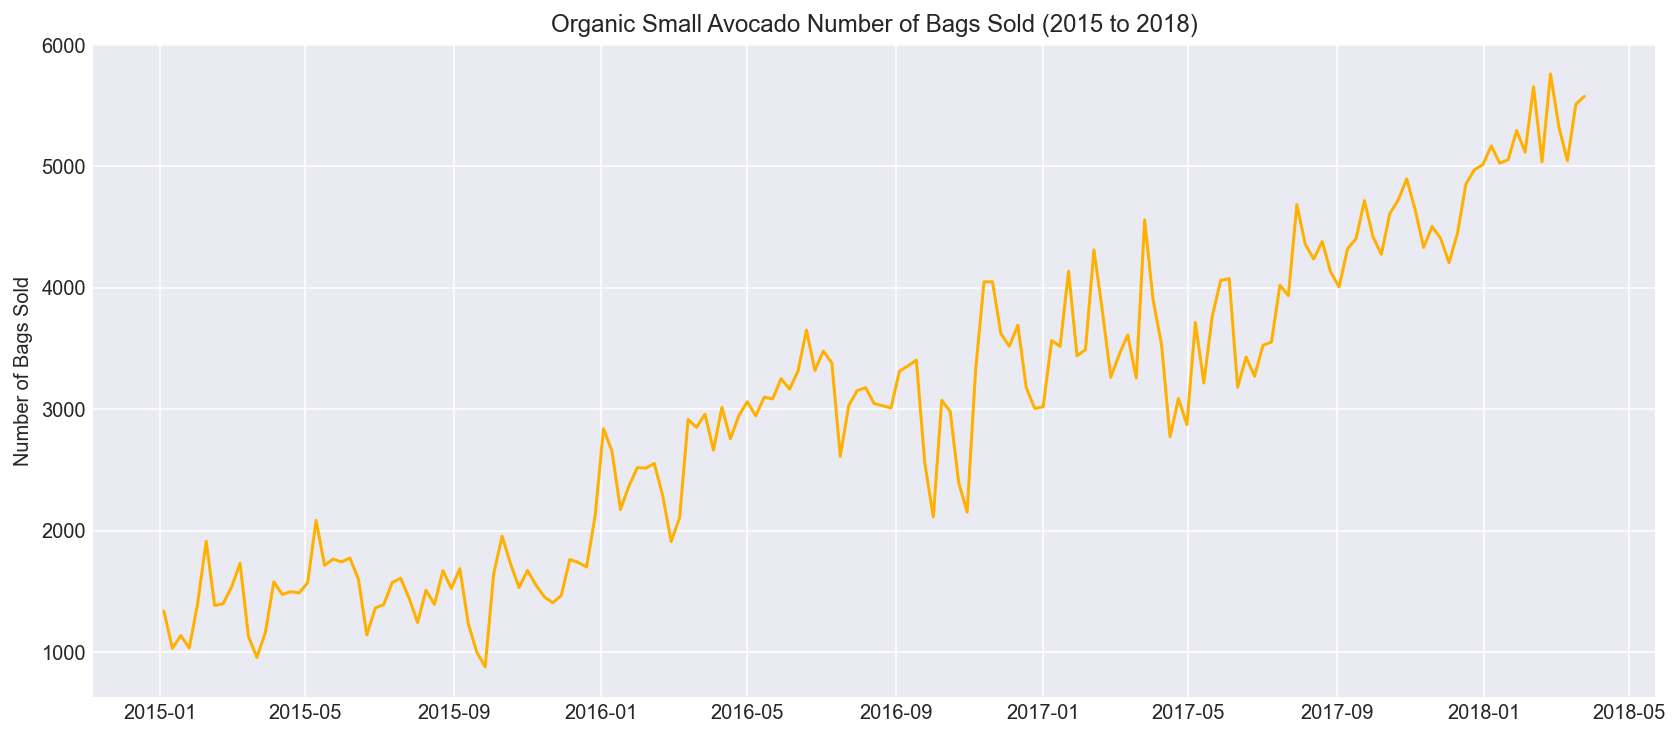

In [45]:
data = (
        avocado_sales
            .query('type_size == "organic, small"'))
ax = (
        sns
            .lineplot(
            data = data ,
            x = 'date',
            y = 'nb_sold', 
            color='#FFB000',
            ci = None)

)
ax.set (
    ylabel = 'Number of Bags Sold',
    xlabel = None,
    title = 'Organic Small Avocado Number of Bags Sold (2015 to 2018)'
)
plt.show()

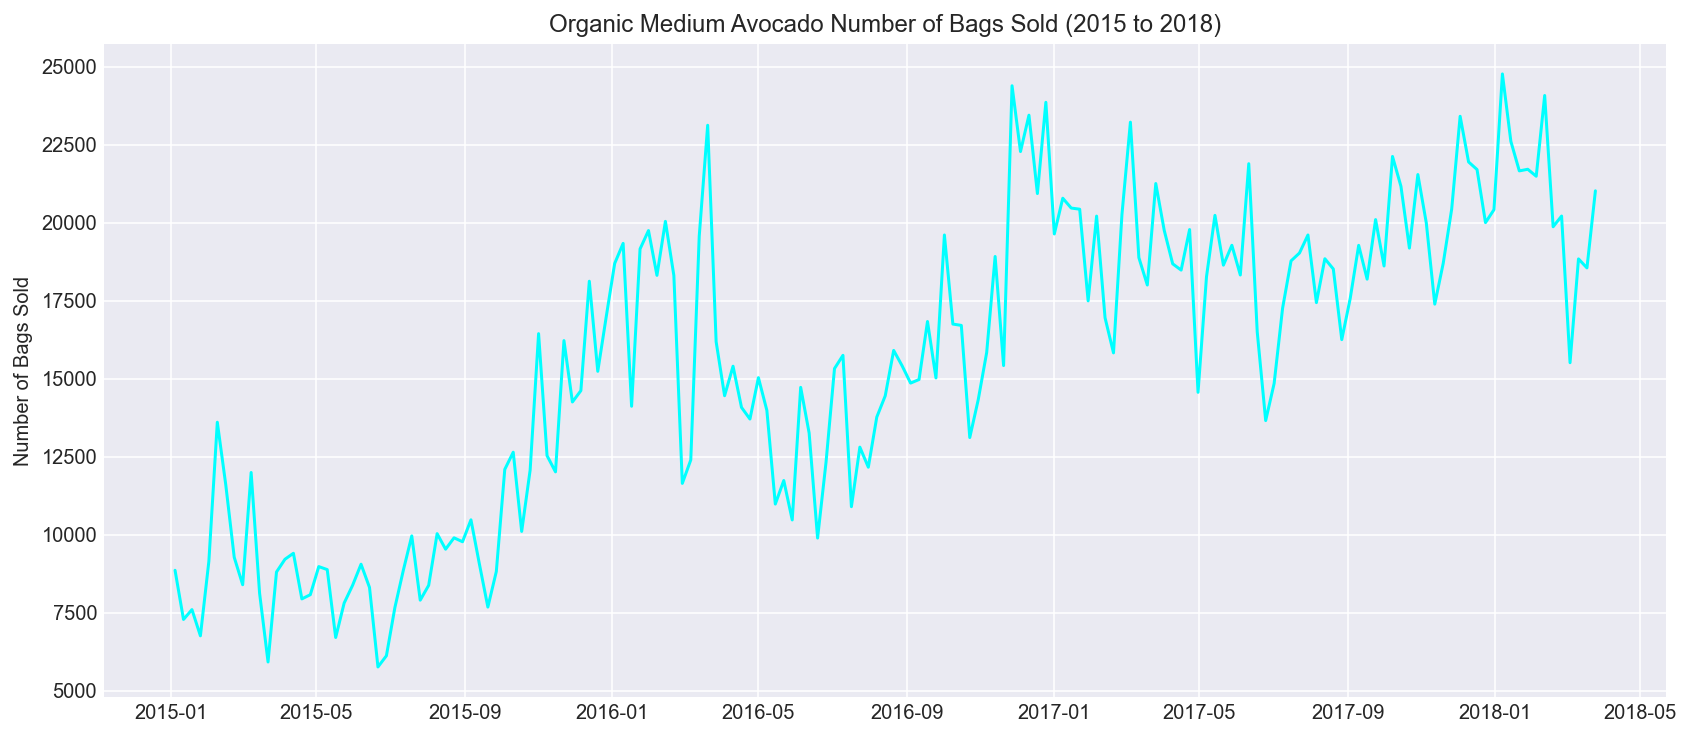

In [46]:
data = (
        avocado_sales
            .query('type_size == "organic, medium"'))
ax = (
        sns
            .lineplot(
            data = data ,
            x = 'date',
            y = 'nb_sold', 
            color='#00FFFF',
            ci = None)

)
ax.set (
    ylabel = 'Number of Bags Sold',
    xlabel = None,
    title = 'Organic Medium Avocado Number of Bags Sold (2015 to 2018)'
)
plt.show()

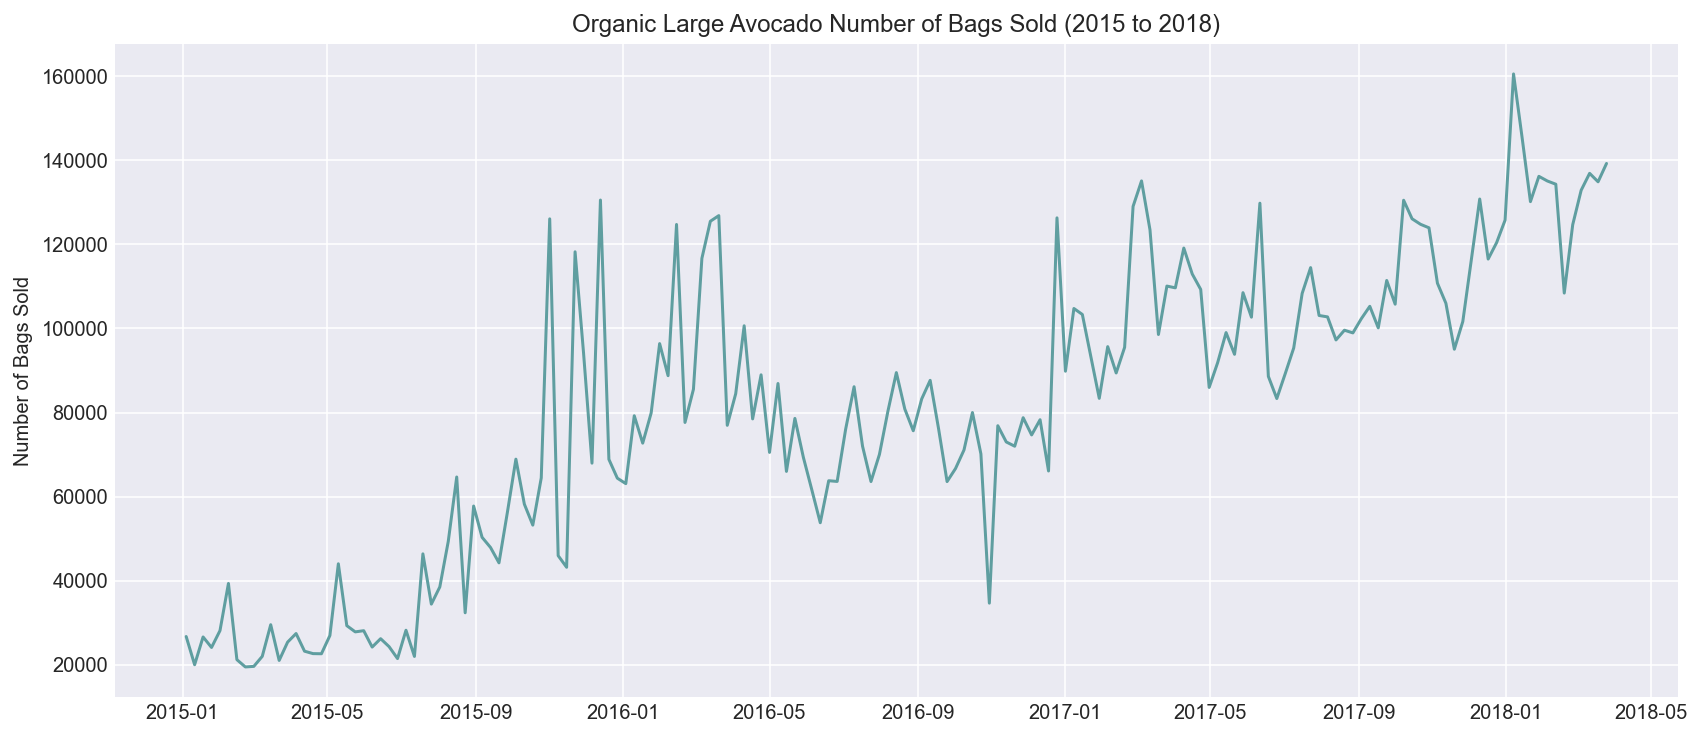

In [47]:
data = (
        avocado_sales
            .query('type_size == "organic, large"'))
ax = (
        sns
            .lineplot(
            data = data ,
            x = 'date',
            y = 'nb_sold', 
            color='#5f9ea0',
            ci = None)

)
ax.set (
    ylabel = 'Number of Bags Sold',
    xlabel = None,
    title = 'Organic Large Avocado Number of Bags Sold (2015 to 2018)'
)
plt.show()

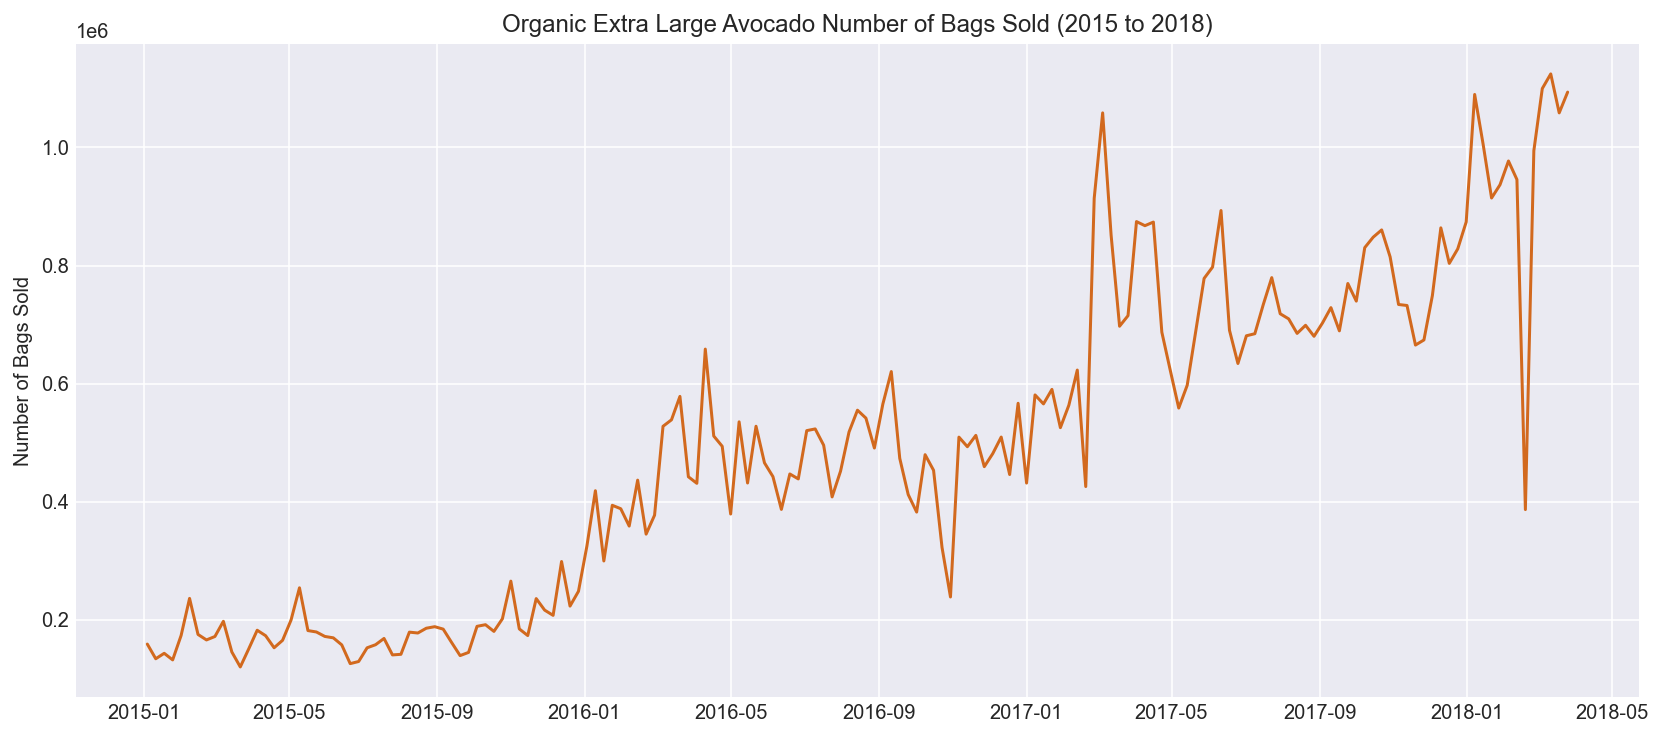

In [48]:
data = (
        avocado_sales
            .query('type_size == "organic, extra large"'))
ax = (
        sns
            .lineplot(
            data = data ,
            x = 'date',
            y = 'nb_sold', 
            color='#d2691e',
            ci = None)

)
ax.set (
    ylabel = 'Number of Bags Sold',
    xlabel = None,
    title = 'Organic Extra Large Avocado Number of Bags Sold (2015 to 2018)'
)
plt.show()